In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve



In [40]:
# Load data
data = pd.read_csv('Close2AdmitDataWithRV.csv')

# Clean data
data = data.dropna(subset=['RV Dysfunction'])
data = data[data['RV Dysfunction'] != '0']

''' Select features
columns_to_exclude = ['patid', 'patkey', 'TTEDate', 'AVr_str', 'PVr_str', 'TVr_str', 'MVr_str']
'''

" Select features\ncolumns_to_exclude = ['patid', 'patkey', 'TTEDate', 'AVr_str', 'PVr_str', 'TVr_str', 'MVr_str']\n"

In [41]:
import numpy as np
import pandas as pd

def calculate_cardiac_indices(df):
    """
    Calculate cardiac indices for clinical or computational datasets with flexible column mapping.
    """
    if 'LVIDd' in df.columns:
        LVIDd_col = 'LVIDd'
        LVIDs_col = 'LVIDs'
        LVEF_col = 'LVEF_tte'
        NIBPd_col = 'NIBPd_vitals'
        NIBPs_col = 'NIBPs_vitals'
        PCW_col = 'PCW'
        RAm_col = 'RAm'
        CO_col = 'CO_fick'
        PAs_col = 'PAs'
        PAd_col = 'PAd'
        IVSd_col = 'IVSd'
        Height_col = 'Height'
        Weight_col = 'Weight'
    else:
        LVIDd_col = 'LVIDd_S'
        LVIDs_col = 'LVIDs_S'
        LVEF_col = 'EF_S'
        NIBPd_col = 'DBP_S'
        NIBPs_col = 'SBP_S'
        PCW_col = 'PCWP_S'
        RAm_col = 'RAPmean_S'
        CO_col = 'CO_S'
        PAs_col = 'PASP_S'
        PAd_col = 'PADP_S'
        IVSd_col = 'IVSd_S' if 'IVSd_S' in df.columns else LVIDs_col
        Height_col = 'Height' if 'Height' in df.columns else None
        Weight_col = 'Weight' if 'Weight' in df.columns else None

    df['LVIDd_cm'] = df[LVIDd_col] / 10
    df['LVEDV'] = (4 / 3) * np.pi * (df['LVIDd_cm'] / 2) ** 3
    df['LVEF_frac'] = df[LVEF_col] * 0.01
    df['LVSV'] = df['LVEDV'] * df['LVEF_frac']
    df['mean_BP'] = (2 / 3 * df[NIBPd_col]) + (1 / 3 * df[NIBPs_col])
    df['BSA'] = 0.007184 * (df[Weight_col] ** 0.425) * (df[Height_col] ** 0.725) if Height_col and Weight_col else 1.8
    df['LVSWI'] = df['LVSV'] * (df['mean_BP'] - df[PCW_col]) * 0.0136 / df['BSA']
    df['PAm'] = (df[PAs_col] + 2 * df[PAd_col]) / 3
    df['RVSWI_calc'] = df['LVSV'] * (df['PAm'] - df[RAm_col]) * 0.0136 / df['BSA']
    df['stress'] = df[PCW_col] * (df['LVIDd_cm'] / 2) / (2 * df[IVSd_col])
    df['strain'] = (df['LVIDd_cm'] - df[LVIDs_col]) / df[LVIDs_col]
    df['LV_stiffness'] = df['stress'] / df['strain']
    df['Passive_Cardiac_Index'] = df[RAm_col] * df[CO_col] / (df[PCW_col] * df['BSA'])

    return df


In [42]:
'''missing_percentages = data.isnull().mean() * 100
data = calculate_cardiac_indices(data)
#data = data.drop(columns=columns_to_exclude)
# Identify columns with more than 20% missing data
columns_to_drop = missing_percentages[missing_percentages > 20].index

# Drop these columns from the dataset
data = data.drop(columns=columns_to_drop)

# Display the columns dropped
print(f"Columns dropped: {columns_to_drop.tolist()}")'''

'missing_percentages = data.isnull().mean() * 100\ndata = calculate_cardiac_indices(data)\n#data = data.drop(columns=columns_to_exclude)\n# Identify columns with more than 20% missing data\ncolumns_to_drop = missing_percentages[missing_percentages > 20].index\n\n# Drop these columns from the dataset\ndata = data.drop(columns=columns_to_drop)\n\n# Display the columns dropped\nprint(f"Columns dropped: {columns_to_drop.tolist()}")'

In [43]:
'''#drop patients where more than 20% missing
missing_percentage = data.isnull().mean(axis=1)

# Keep only the rows where missing percentage is <= 0.2 (20%)
df_cleaned = data[missing_percentage <= 0.2]

# Reset index if desired
data = df_cleaned.reset_index(drop=True)'''

'#drop patients where more than 20% missing\nmissing_percentage = data.isnull().mean(axis=1)\n\n# Keep only the rows where missing percentage is <= 0.2 (20%)\ndf_cleaned = data[missing_percentage <= 0.2]\n\n# Reset index if desired\ndata = df_cleaned.reset_index(drop=True)'

In [44]:
# Convert 'Birthday' to Age
'''if 'Birthday' in data.columns:
    data['Birthday'] = pd.to_datetime(data['Birthday'], format="%d-%b-%y", errors='coerce')
    data = data.dropna(subset=['Birthday'])  # Drop rows where Birthday conversion failed

    today = pd.to_datetime('today')
    data['Age'] = (today - data['Birthday']).dt.days / 365.25  

data = data.drop(columns=['Birthday'], errors='ignore')

# Select numerical features for X
X = data.select_dtypes(include=[np.number]).drop(columns=['RV Dysfunction'], errors='ignore')
#print(X.head())'''

'if \'Birthday\' in data.columns:\n    data[\'Birthday\'] = pd.to_datetime(data[\'Birthday\'], format="%d-%b-%y", errors=\'coerce\')\n    data = data.dropna(subset=[\'Birthday\'])  # Drop rows where Birthday conversion failed\n\n    today = pd.to_datetime(\'today\')\n    data[\'Age\'] = (today - data[\'Birthday\']).dt.days / 365.25  \n\ndata = data.drop(columns=[\'Birthday\'], errors=\'ignore\')\n\n# Select numerical features for X\nX = data.select_dtypes(include=[np.number]).drop(columns=[\'RV Dysfunction\'], errors=\'ignore\')\n#print(X.head())'

In [45]:
'''from sklearn.impute import KNNImputer
# Initialize the KNN imputer
# You can adjust n_neighbors as needed
X = X.replace([np.inf, -np.inf], np.nan)

knn_imputer = KNNImputer(n_neighbors=5)

# Get the feature names for later use
feature_names = X.columns

# Apply KNN imputation to your features
X_imputed = knn_imputer.fit_transform(X)

# Convert back to DataFrame to preserve column names
X = pd.DataFrame(X_imputed, columns=feature_names)

# Then continue with standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)'''

'from sklearn.impute import KNNImputer\n# Initialize the KNN imputer\n# You can adjust n_neighbors as needed\nX = X.replace([np.inf, -np.inf], np.nan)\n\nknn_imputer = KNNImputer(n_neighbors=5)\n\n# Get the feature names for later use\nfeature_names = X.columns\n\n# Apply KNN imputation to your features\nX_imputed = knn_imputer.fit_transform(X)\n\n# Convert back to DataFrame to preserve column names\nX = pd.DataFrame(X_imputed, columns=feature_names)\n\n# Then continue with standardization\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X)'

In [46]:
# Encode target variable into binary labels
'''Y = data['RV Dysfunction'].replace({
    'Moderate': 'High Dysfunction',
    'Severe': 'High Dysfunction',
    'Normal': 'Low Dysfunction',
    'Mild': 'Low Dysfunction'
})

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_encoded, test_size=0.2, random_state=42)
'''

"Y = data['RV Dysfunction'].replace({\n    'Moderate': 'High Dysfunction',\n    'Severe': 'High Dysfunction',\n    'Normal': 'Low Dysfunction',\n    'Mild': 'Low Dysfunction'\n})\n\nlabel_encoder = LabelEncoder()\nY_encoded = label_encoder.fit_transform(Y)\n\n# Standardize features\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X)\n\n# Split data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_encoded, test_size=0.2, random_state=42)\n"

In [47]:
'''print("Class distribution:", np.bincount(y_train))
print("Classes",np.unique(Y) )'''

'print("Class distribution:", np.bincount(y_train))\nprint("Classes",np.unique(Y) )'

In [48]:
def train_and_evaluate(model, model_name, X_train, Y_train, X_test, Y_test):
    """
    Trains and evaluates a classification model.
    Prints classification report, confusion matrix, and calculates ROC AUC.
    """
    print(f"\n--- {model_name} ---")

    # Train the model
    model.fit(X_train, Y_train)

    # Make predictions
    Y_pred = model.predict(X_test)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(Y_test, Y_pred))

    # Print confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(Y_test, Y_pred)
    cm_df = pd.DataFrame(cm)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='flare')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Calculate ROC AUC
    if hasattr(model, "predict_proba"):  # Ensure the model supports probability predictions
        Y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1
        roc_auc = roc_auc_score(Y_test, Y_pred_proba)

        print(f"ROC AUC: {roc_auc:.4f}")

        # Plot ROC Curve
        fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
    
    return model

In [49]:
'''logistic_model = LogisticRegression(
    random_state=42,  # For reproducibility
    max_iter=1000,    # Increase max iterations to ensure convergence
    class_weight='balanced'  # Handle class imbalance
)

# Train and evaluate Logistic Regression
logistic_regression_model = train_and_evaluate(
    logistic_model, 
    "Logistic Regression", 
    X_train, 
    y_train, 
    X_test, 
    y_test
)

# Optional: Perform cross-validation
cv_scores = cross_val_score(logistic_model, X_scaled, Y_encoded, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
print("\nCross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())

# Optional: Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(logistic_regression_model.coef_[0])
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(20))

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20), palette='viridis')
plt.title('Top 10 Most Important Features - Logistic Regression')
plt.xlabel('Absolute Coefficient Magnitude')
plt.tight_layout()
plt.show()'''

'logistic_model = LogisticRegression(\n    random_state=42,  # For reproducibility\n    max_iter=1000,    # Increase max iterations to ensure convergence\n    class_weight=\'balanced\'  # Handle class imbalance\n)\n\n# Train and evaluate Logistic Regression\nlogistic_regression_model = train_and_evaluate(\n    logistic_model, \n    "Logistic Regression", \n    X_train, \n    y_train, \n    X_test, \n    y_test\n)\n\n# Optional: Perform cross-validation\ncv_scores = cross_val_score(logistic_model, X_scaled, Y_encoded, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))\nprint("\nCross-Validation Scores:", cv_scores)\nprint("Mean CV Score:", cv_scores.mean())\nprint("Standard Deviation of CV Scores:", cv_scores.std())\n\n# Optional: Feature importance (coefficients)\nfeature_importance = pd.DataFrame({\n    \'feature\': feature_names,\n    \'importance\': np.abs(logistic_regression_model.coef_[0])\n})\nfeature_importance = feature_importance.sort_values(\'importance\', ascendi

In [61]:
def get_roc_data(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    return fpr, tpr, auc

def run_logistic_pipeline(csv_file, label=''):
    print(f"\n========== Running Logistic Model on: {label} ==========\n")
    data = pd.read_csv(csv_file)

    data = data.dropna(subset=['RV Dysfunction'])
    data = data[data['RV Dysfunction'] != '0']

    # Convert Birthday to Age
    if 'Birthday' in data.columns:
        data['Birthday'] = pd.to_datetime(data['Birthday'], format="%d-%b-%y", errors='coerce')
        data = data.dropna(subset=['Birthday'])
        today = pd.to_datetime('today')
        data['Age'] = (today - data['Birthday']).dt.days / 365.25
        data = data.drop(columns=['Birthday'], errors='ignore')

    # Add cardiac indices
    data = calculate_cardiac_indices(data)

    # Drop columns with too much missing
    missing_percentages = data.isnull().mean() * 100
    columns_to_drop = missing_percentages[missing_percentages > 20].index
    data = data.drop(columns=columns_to_drop)

    # Drop rows with too much missing
    missing_percentage = data.isnull().mean(axis=1)
    data = data[missing_percentage <= 0.2].reset_index(drop=True)

    # Select numerical features for X
    X = data.select_dtypes(include=[np.number]).drop(columns=['RV Dysfunction'], errors='ignore')
    X = X.replace([np.inf, -np.inf], np.nan)

    # Impute and scale
    knn_imputer = KNNImputer(n_neighbors=5)
    X = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Encode Y
    Y = data['RV Dysfunction'].replace({
        'Moderate': 'High Dysfunction',
        'Severe': 'High Dysfunction',
        'Normal': 'Low Dysfunction',
        'Mild': 'Low Dysfunction'
    })

    label_encoder = LabelEncoder()
    Y_encoded = label_encoder.fit_transform(Y)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_encoded, test_size=0.2, random_state=42)

    # Train and evaluate
    logistic_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
    trained_model = train_and_evaluate(logistic_model, f"{label} - Logistic Regression", X_train, y_train, X_test, y_test)

    # Feature importance plot (absolute value of coefficients)
    feature_names = X.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.abs(trained_model.coef_[0])
    }).sort_values('Importance', ascending=False)

    print(f"\nTop Features for {label}:\n", importance_df.head(10))

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='flare')
    plt.title(f'Top Logistic Regression Features - {label}')
    plt.xlabel('Absolute Coefficient Magnitude')
    plt.tight_layout()
    plt.show()

    # ROC data for plotting
    fpr, tpr, auc = get_roc_data(logistic_model, X_train, y_train, X_test, y_test)
    return label, fpr, tpr, auc




========== Running Logistic Model on: Patient ==========


--- Patient - Logistic Regression ---

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.51      0.48        39
           1       0.57      0.51      0.54        49

    accuracy                           0.51        88
   macro avg       0.51      0.51      0.51        88
weighted avg       0.52      0.51      0.51        88


Confusion Matrix:


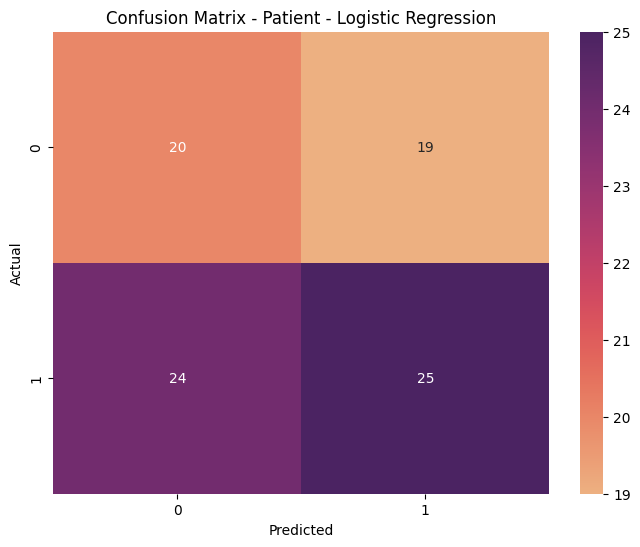

ROC AUC: 0.5877


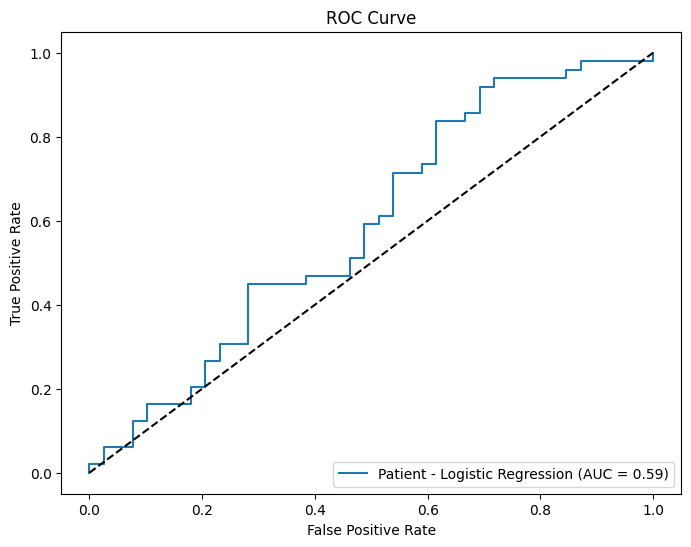


Top Features for Patient:
      Feature  Importance
4    CO_fick    0.690296
6       PCWa    0.516306
8        PAs    0.500740
10       RVs    0.442680
5        PCW    0.426103
44     LVSWI    0.420778
3      CO_td    0.364010
38  LVIDd_cm    0.358874
25     LVIDd    0.358874
14       RAv    0.357023


/var/folders/dz/fbr6_yrs1qd7cqdgs7l6dw780000gn/T/ipykernel_91071/746192650.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='flare')


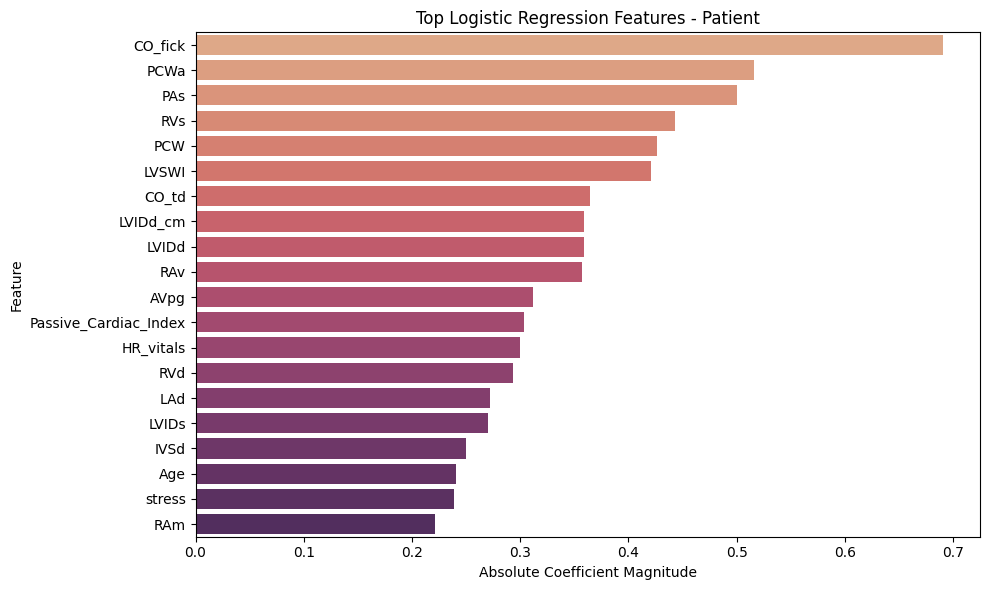


========== Running Logistic Model on: Computational ==========


--- Computational - Logistic Regression ---

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.65      0.57        37
           1       0.69      0.56      0.62        52

    accuracy                           0.60        89
   macro avg       0.60      0.60      0.59        89
weighted avg       0.62      0.60      0.60        89


Confusion Matrix:


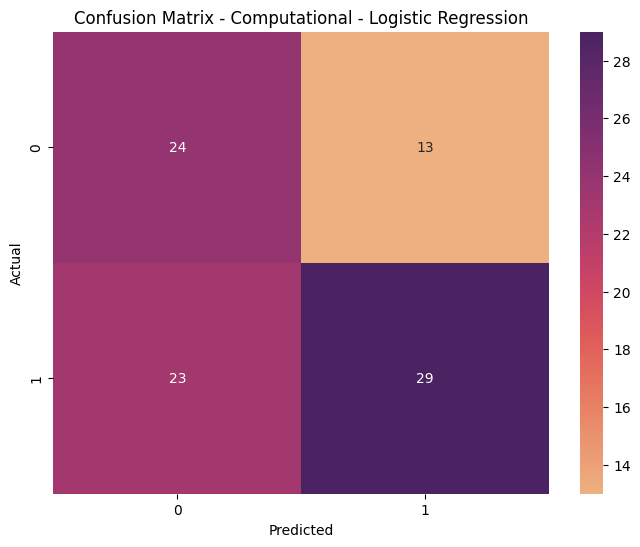

ROC AUC: 0.6149


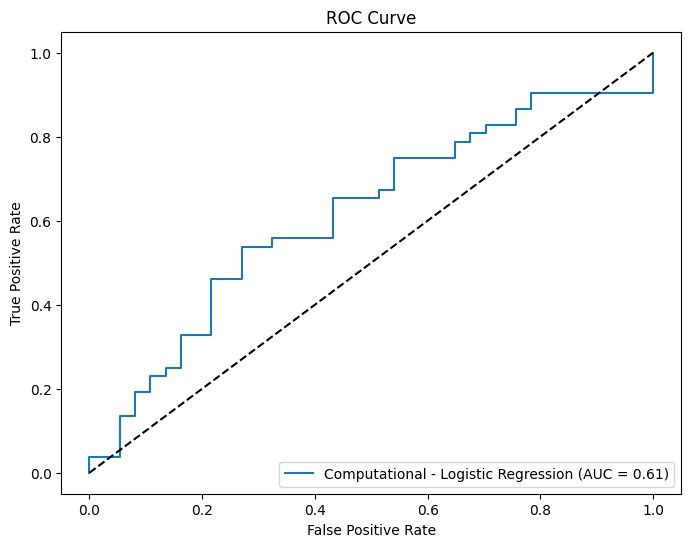


Top Features for Computational:
        Feature  Importance
91      strain    0.916254
9        Vw_RV    0.820321
40   PCWPmax_S    0.817606
11    Amref_LV    0.704704
75     RVSWI_S    0.651013
4     k_act_LV    0.616154
36    minRVP_S    0.615513
50     RVESV_S    0.572090
70  StrainRV_S    0.569922
76       PVR_S    0.508683


/var/folders/dz/fbr6_yrs1qd7cqdgs7l6dw780000gn/T/ipykernel_91071/746192650.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='flare')


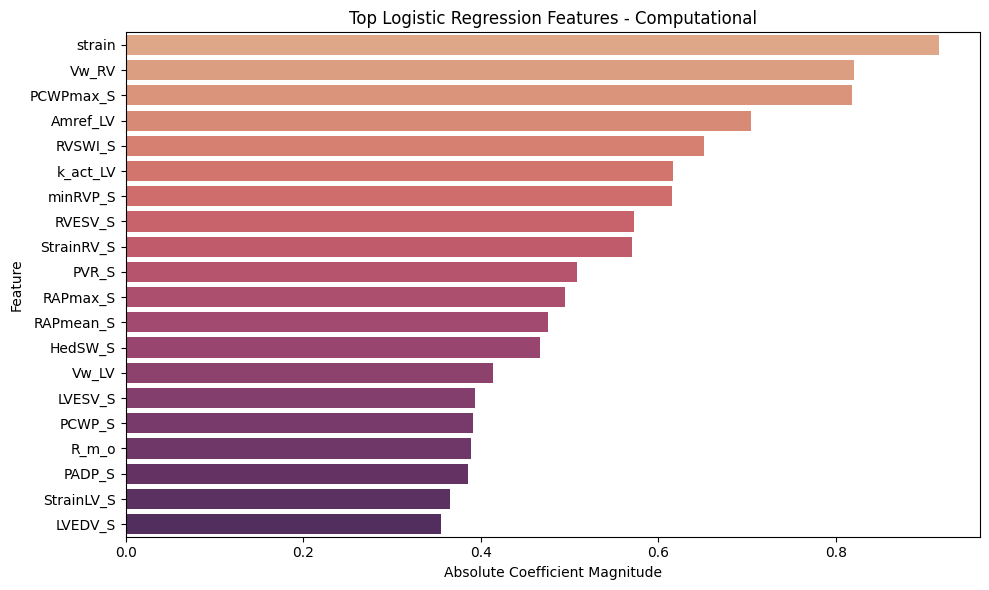


========== Running Logistic Model on: Combined ==========


--- Combined - Logistic Regression ---

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.50      0.49        36
           1       0.65      0.62      0.63        53

    accuracy                           0.57        89
   macro avg       0.56      0.56      0.56        89
weighted avg       0.58      0.57      0.57        89


Confusion Matrix:


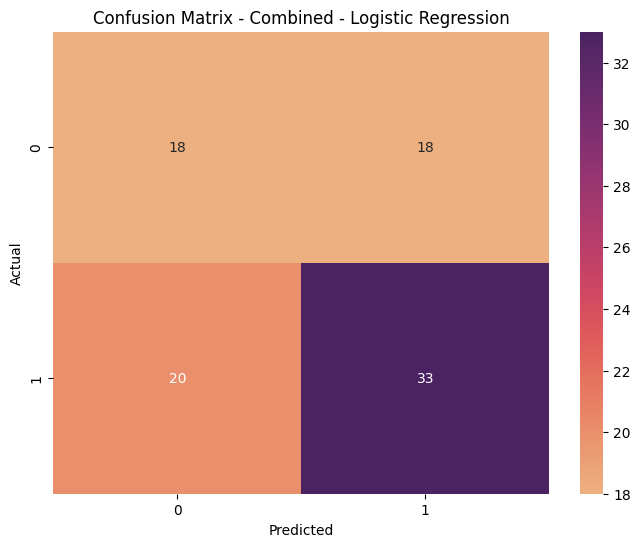

ROC AUC: 0.5776


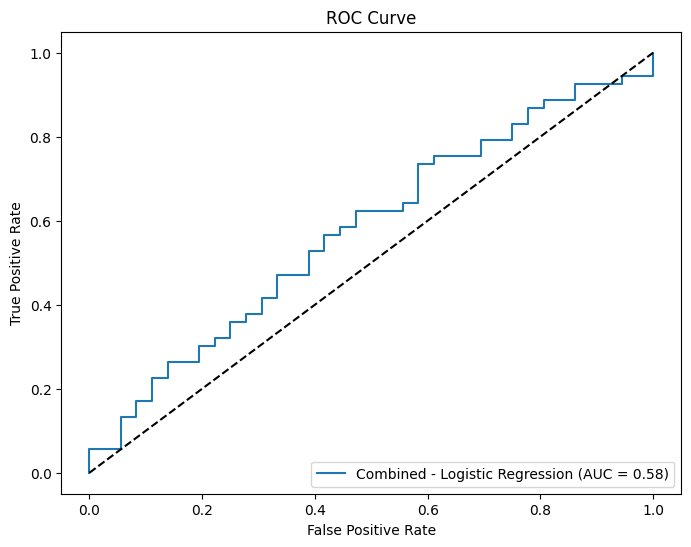


Top Features for Combined:
        Feature  Importance
76      PADP_S    1.199444
113    RVSWI_S    0.891633
26       LVIDs    0.866667
110     RVMD_S    0.796363
78   PCWPmax_S    0.780513
46       Vw_LV    0.777713
4      CO_fick    0.745871
43    k_act_RV    0.736775
90     HedSW_S    0.697784
69       DBP_S    0.692123


/var/folders/dz/fbr6_yrs1qd7cqdgs7l6dw780000gn/T/ipykernel_91071/746192650.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='flare')


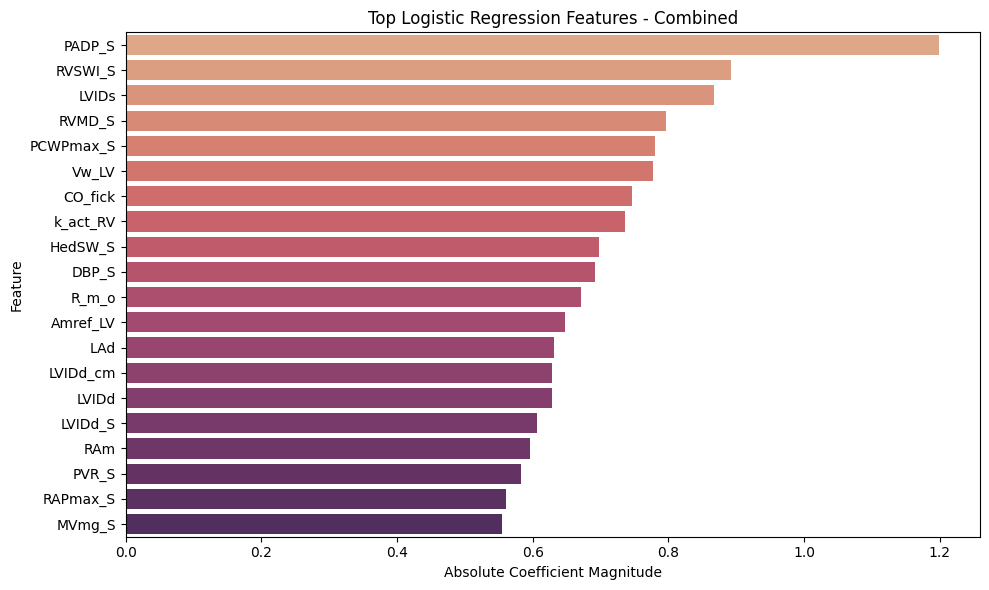

In [62]:
logistic_results = [
    run_logistic_pipeline("Close2AdmitDataWithRV.csv", "Patient"),
    run_logistic_pipeline("Close2AdmitDTinfo.csv", "Computational"),
    run_logistic_pipeline("CombinedDataWithRV.csv", "Combined")
]
